In [ ]:
%matplotlib inline

import sys
from cartopy.io.img_tiles import OSM 
from dateutil.relativedelta import relativedelta
from matplotlib.path import Path 
from matplotlib.transforms import offset_copy 
from PIL import Image 
from sklearn.metrics import r2_score
import airquality.data_analysis as an
import airquality.plots as plot
import airquality.read_data as read
import cartopy.crs as ccrs 
import cartopy.io.img_tiles as cimgt 
import datetime
import datetime
import datetime as dt
import locale
import matplotlib
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats
import six 
import sys
matplotlib.use('Template')
prop = fm.FontProperties(fname='/home/calidadaire/ModuloAire/Tools/AvenirLTStd-Heavy.ttf',)
prop_1 = fm.FontProperties(fname='/home/calidadaire/ModuloAire/Tools/AvenirLTStd-Book.ttf',)
prop_2 = fm.FontProperties(fname='/home/calidadaire/ModuloAire/Tools/AvenirLTStd-Black.ttf',)


/home/amontejo/py_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# We merge the raw files downloaded from the last year

(Last year 2024)

These files are downloaded from the portal and formatted to match the historical dataset we have been compiling for Bogotá.

In [ ]:
# Path to the 2024 data files -- modify for 202@
data_path_2024 = '/home/amontejo/jupyter/PM2.5/Bogota_AMVA_PM25/Datos_Bogota/Datos_Crudos_2024'

# Load and merge all 2024 files
files_2024 = [f for f in os.listdir(data_path_2024) if f.endswith('.xlsx')]
data_2024 = []

for file in files_2024:
    file_path = os.path.join(data_path_2024, file)

    # Load 2024 data with rows 3 and 4 as headers
    df_2024 = pd.read_excel(file_path, skiprows=2, header=[0, 1])

    # Combine rows 3 and 4 to create column names (this matches the historical data format)
    df_2024.columns = ['_'.join(col).strip() for col in df_2024.columns]

    # Rename the DateTime column if it has an unexpected name
    for col in df_2024.columns:
        if 'DateTime' in col:
            df_2024.rename(columns={col: 'DateTime'}, inplace=True)

    # Ensure 'DateTime' column is present
    if 'DateTime' not in df_2024.columns:
        raise KeyError(f"'DateTime' is not correctly present in the file: {file}")

    # Convert 'DateTime' column to the historical format
    df_2024['DateTime'] = pd.to_datetime(df_2024['DateTime'], format='%d-%m-%Y %H:%M', errors='coerce')

    # Adjust column names to match the historical format
    def adjust_column_names(columns):
        adjusted_columns = []
        for col in columns:
            if col == "DateTime":  # Keep the date column unchanged
                adjusted_columns.append(col)
            else:
                parts = col.split("_")
                if len(parts) == 2:
                    col_adjusted = f"{parts[1]}_{parts[0]}"
                    adjusted_columns.append(col_adjusted)
                else:
                    adjusted_columns.append(col)  # Leave unchanged if the format doesn't match
        return adjusted_columns

    # Rename columns to the historical format
    df_2024.columns = adjust_column_names(df_2024.columns)

    # Add the processed DataFrame to the list
    data_2024.append(df_2024)
    print(f"File {file} successfully processed.")

# Merge all 2024 data into a single DataFrame
complete_data_2024 = pd.concat(data_2024, ignore_index=True)

# Remove rows with null dates
complete_data_2024 = complete_data_2024.dropna(subset=['DateTime'])

# Confirm that the dates are correctly formatted
print(f"First processed dates: {complete_data_2024['DateTime'].head()}")

# Save the processed 2024 data to an intermediate file (optional)
output_path_2024 = '/home/amontejo/jupyter/PM2.5/Bogota_AMVA_PM25/Datos_Bogota/Datos_2024_Procesados.xlsx'
complete_data_2024.to_excel(output_path_2024, index=False)
print(f"Processed 2024 data saved at: {output_path_2024}")


Archivo StationsReport_20250817437.xlsx procesado con éxito.
Archivo StationsReport_202508172035.xlsx procesado con éxito.
Archivo StationsReport_20250817553.xlsx procesado con éxito.
Archivo StationsReport_20250817193.xlsx procesado con éxito.
Primeras fechas después de procesar: 1   2024-01-01 01:00:00
2   2024-01-01 02:00:00
3   2024-01-01 03:00:00
4   2024-01-01 04:00:00
5   2024-01-01 05:00:00
Name: DateTime, dtype: datetime64[ns]
Datos de 2024 procesados y guardados en: /home/amontejo/jupyter/PM2.5/Bogota_AMVA_PM25/Datos_Bogota/Datos_2024_Procesados.xlsx


# Concatenate with the historical dataset

 - This step is necessary because we already have a historical database up to 2023.
 - We merge the newly processed 2024 data with the existing dataset to maintain continuity.


In [ ]:
# File paths
historical_data_path = '/home/amontejo/jupyter/PM2.5/Bogota_AMVA_PM25/Datos_Bogota/Datos_RMCAB_2023.xlsx'
data_2024_path = '/home/amontejo/jupyter/PM2.5/Bogota_AMVA_PM25/Datos_Bogota/Datos_2024_Procesados.xlsx'
output_historical_path = '/home/amontejo/jupyter/PM2.5/Bogota_AMVA_PM25/Datos_Bogota/Datos_Bog_Historicos.xlsx'

# Load the historical dataset
historical_df = pd.read_excel(historical_data_path, header=0, parse_dates=['DateTime'])

# Load the processed 2024 data
data_2024_df = pd.read_excel(data_2024_path, header=0, parse_dates=['DateTime'])

# Find common columns between both DataFrames
common_columns = historical_df.columns.intersection(data_2024_df.columns)

# Filter both DataFrames to retain only common columns
historical_df = historical_df[common_columns]
data_2024_df = data_2024_df[common_columns]

# Concatenate the data
complete_data = pd.concat([historical_df, data_2024_df], ignore_index=True)

# Sort by date
complete_data.sort_values(by='DateTime', inplace=True)

# Reset the index
complete_data.reset_index(drop=True, inplace=True)

# Save the updated historical dataset
complete_data.to_excel(output_historical_path, index=False)

print(f"New historical dataset created at: {output_historical_path}")
print(f"Final dataset shape: {complete_data.shape}")



Nuevo archivo histórico creado en: /home/amontejo/jupyter/PM2.5/Bogota_AMVA_PM25/Datos_Bogota/Datos_Bog_Historicos.xlsx
Forma del archivo final: (10157, 31)


# Generate graphs for PM10 and PM2.5
- **Graph Description**:
  - The graph represents **monthly average PM2.5 concentrations** from **2019 to 2024**.
  - Each colored line corresponds to a different year, showing **seasonal trends**.

- **Key Observations**:
  - PM2.5 levels peak in **March-April**, with the highest values recorded in 2020 and 2024.
  - The lowest concentrations occur between **May and July**, reflecting seasonal improvements in air quality.
  - A gradual increase is observed from **August to December**, indicating a secondary pollution season.
  - The year 2020 shows a significant peak in **March**, likely influenced by specific atmospheric or emission-related events.

- **Seasonal Trends**:
  - The **March-April** peak is consistent across years, linked to **regional pollution episodes**.
  - The **June-July minimum** aligns with meteorological conditions that promote pollutant dispersion.
  - The **October-November increase** suggests a return of unfavorable atmospheric conditions.

This graph provides insights into the **seasonal behavior of PM2.5 in Bogotá and the AMVA**, supporting air quality management strategies.

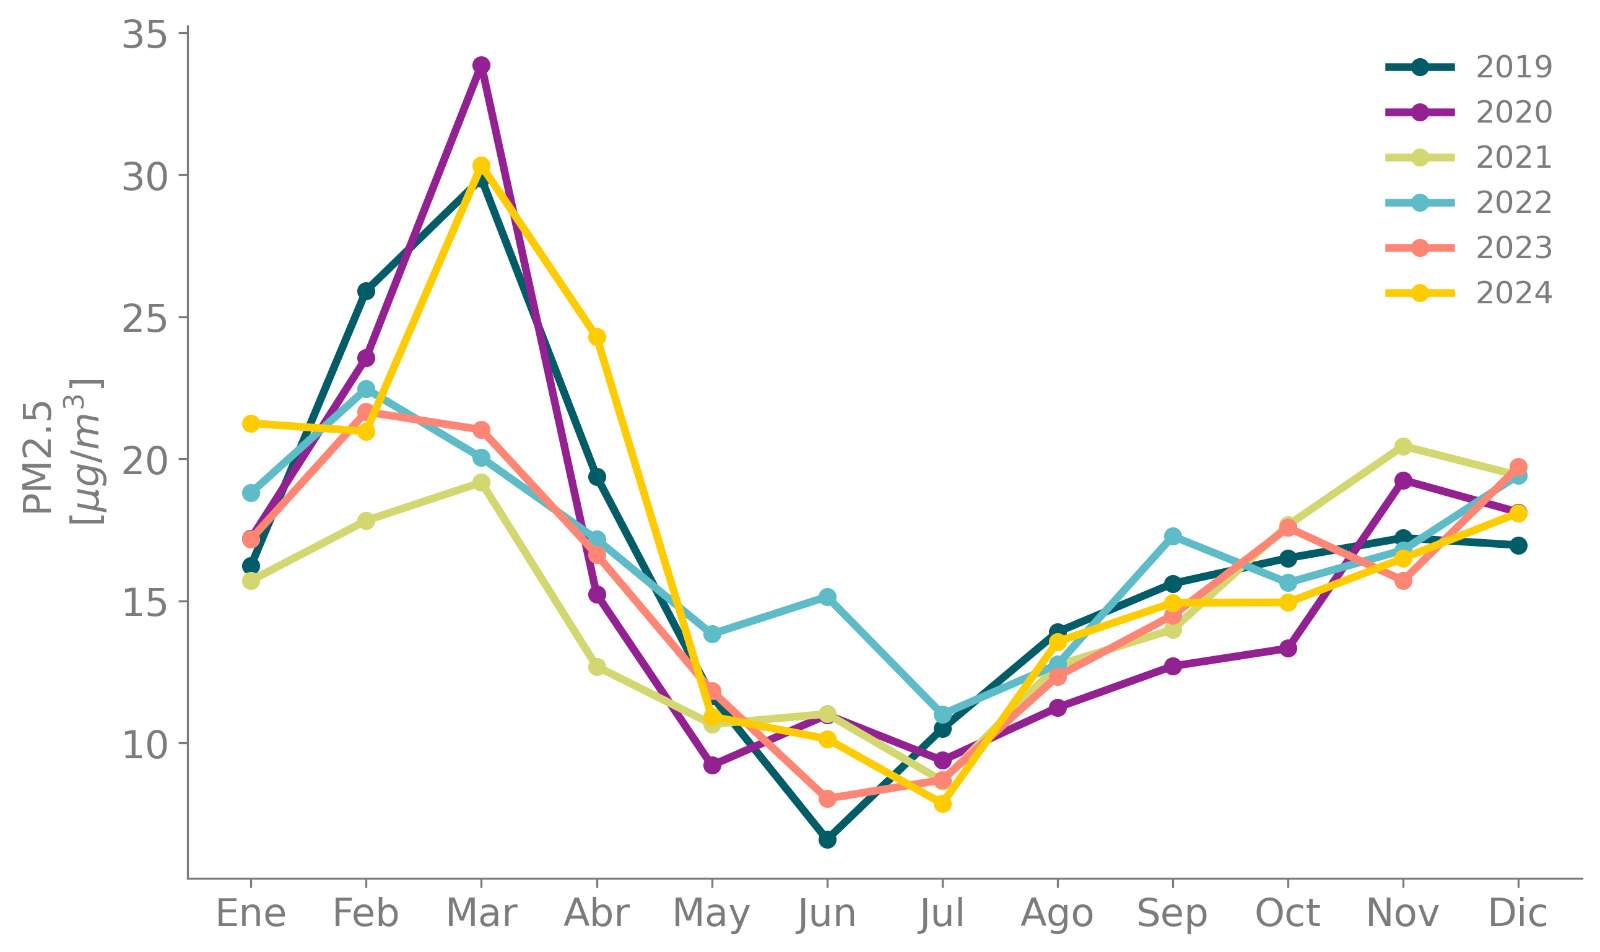

In [ ]:

# Function to process pollutant data
def process_pollutant_data(df, column_name):
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
    pollutant_month = df[[column_name]].resample('M').mean().reset_index()
    pollutant_month['Year'] = pollutant_month['DateTime'].dt.year
    pollutant_month['Month'] = pollutant_month['DateTime'].dt.month
    return pollutant_month

# Load the data
dfs = pd.read_excel(
    '/home/amontejo/jupyter/PM2.5/Bogota_AMVA_PM25/Datos_Bogota/Datos_Bog_Historicos.xlsx',
    header=0,
    parse_dates=['DateTime']
)

# Ensure 'DateTime' is set as index
dfs.set_index('DateTime', inplace=True)
dfs = dfs.sort_index()

# Ensure `PM10_` and `PM2.5_` columns are numeric
for col in dfs.filter(like='PM10_').columns:
    dfs[col] = pd.to_numeric(dfs[col], errors='coerce')

for col in dfs.filter(like='PM2.5_').columns:
    dfs[col] = pd.to_numeric(dfs[col], errors='coerce')

# Create 'PM10_average' and 'PM2.5_average' as the mean of their respective columns
dfs['PM10_average'] = dfs.filter(like='PM10_').mean(axis=1)
dfs['PM2.5_average'] = dfs.filter(like='PM2.5_').mean(axis=1)

# Remove rows with NaN values in the averages
dfs = dfs.dropna(subset=['PM10_average', 'PM2.5_average'])

# Process PM10 and PM2.5 data
PM10_month = process_pollutant_data(dfs, 'PM10_average')
PM25_month = process_pollutant_data(dfs, 'PM2.5_average')

# Filter by years
years = [2019, 2020, 2021, 2022, 2023, 2024]
PM10_by_year = {year: PM10_month[PM10_month['Year'] == year] for year in years}
PM25_by_year = {year: PM25_month[PM25_month['Year'] == year] for year in years}


def create_plot(data_by_year, column_name, ylabel, title, output_path):
    fig, ax = plt.subplots(figsize=(8, 5))
    colors = ['#004a54', 'purple', '#C8D15D', '#4FAEBC', '#FF6F61', '#ffc300']
    marker = 'o'

    for year, color in zip(years, colors):
        if not data_by_year[year].empty:
            data_by_year[year].plot(
                x='Month',
                y=column_name,
                ax=ax,
                label=str(year),
                color=color,
                linestyle='-',
                marker=marker,
                linewidth=3
            )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')
    ax.set_ylabel(ylabel, color='dimgrey', fontsize=15)
    ax.tick_params(axis='both', which='both', colors='dimgrey', labelsize=15)
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.set_xlabel('')  # Remove X-axis title

    # Customize legend
    legend = ax.legend(
        loc='upper right',
        fontsize=12,
        frameon=False
    )
    legend.get_frame().set_linewidth(0)
    legend.get_frame().set_edgecolor('none')
    legend.get_frame().set_facecolor('none')
    
    for text in legend.get_texts():
        plt.setp(text, color='dimgrey')
    
    fig.tight_layout()
    fig.set_facecolor('w')
    fig.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f'Graph saved at: {output_path}')
    plt.close(fig)

# Create and save PM10 and PM2.5 graphs
create_plot(
    PM10_by_year,
    column_name='PM10_average',
    ylabel='PM10\n['+'$\mu g/m^{3}$'+']',
    title='Monthly Average PM10',
    output_path='/home/amontejo/jupyter/PM2.5/Bogota_AMVA_PM25/Bogota_PM10_Graph.png'
)

create_plot(
    PM25_by_year,
    column_name='PM2.5_average',
    ylabel='PM2.5\n['+'$\mu g/m^{3}$'+']',
    title='Monthly Average PM2.5',
    output_path='/home/amontejo/jupyter/PM2.5/Bogota_AMVA_PM25/Bogota_PM25_Graph.png'
)



Gráfica guardada en: /home/amontejo/jupyter/PM2.5/Bogota_AMVA_PM25/Bogota_PM10_Graph.png
Gráfica guardada en: /home/amontejo/jupyter/PM2.5/Bogota_AMVA_PM25/Bogota_PM25_Graph.png


# Generate the comparative graph for Bogotá and the Aburrá Valley Metropolitan Area (AMVA)

- **Graph Description**:
  - The graph shows the **monthly average PM10 and PM2.5 concentrations** from **2019 to 2024** for **Bogotá and AMVA**.
  - Each pollutant is represented separately for both cities.

- **Key Observations**:
  - **Higher PM10 and PM2.5 levels in AMVA** (darker purple and pink lines) compared to Bogotá.
  - **Seasonal peaks** in **March and October** (vertical dashed lines), corresponding to pollution episodes.
  - The most significant pollution spikes occurred in **2020 and 2024**, particularly for PM10 in AMVA.
  - PM10 concentrations are consistently **higher than PM2.5**, reflecting the contribution of coarse particulate matter.

- **Seasonal Trends**:
  - **March (black dashed lines)** and **October (yellow dashed lines)** mark recurrent air pollution seasons.
  - Pollution levels tend to **drop mid-year (June–July)** and rise again towards the end of the year.

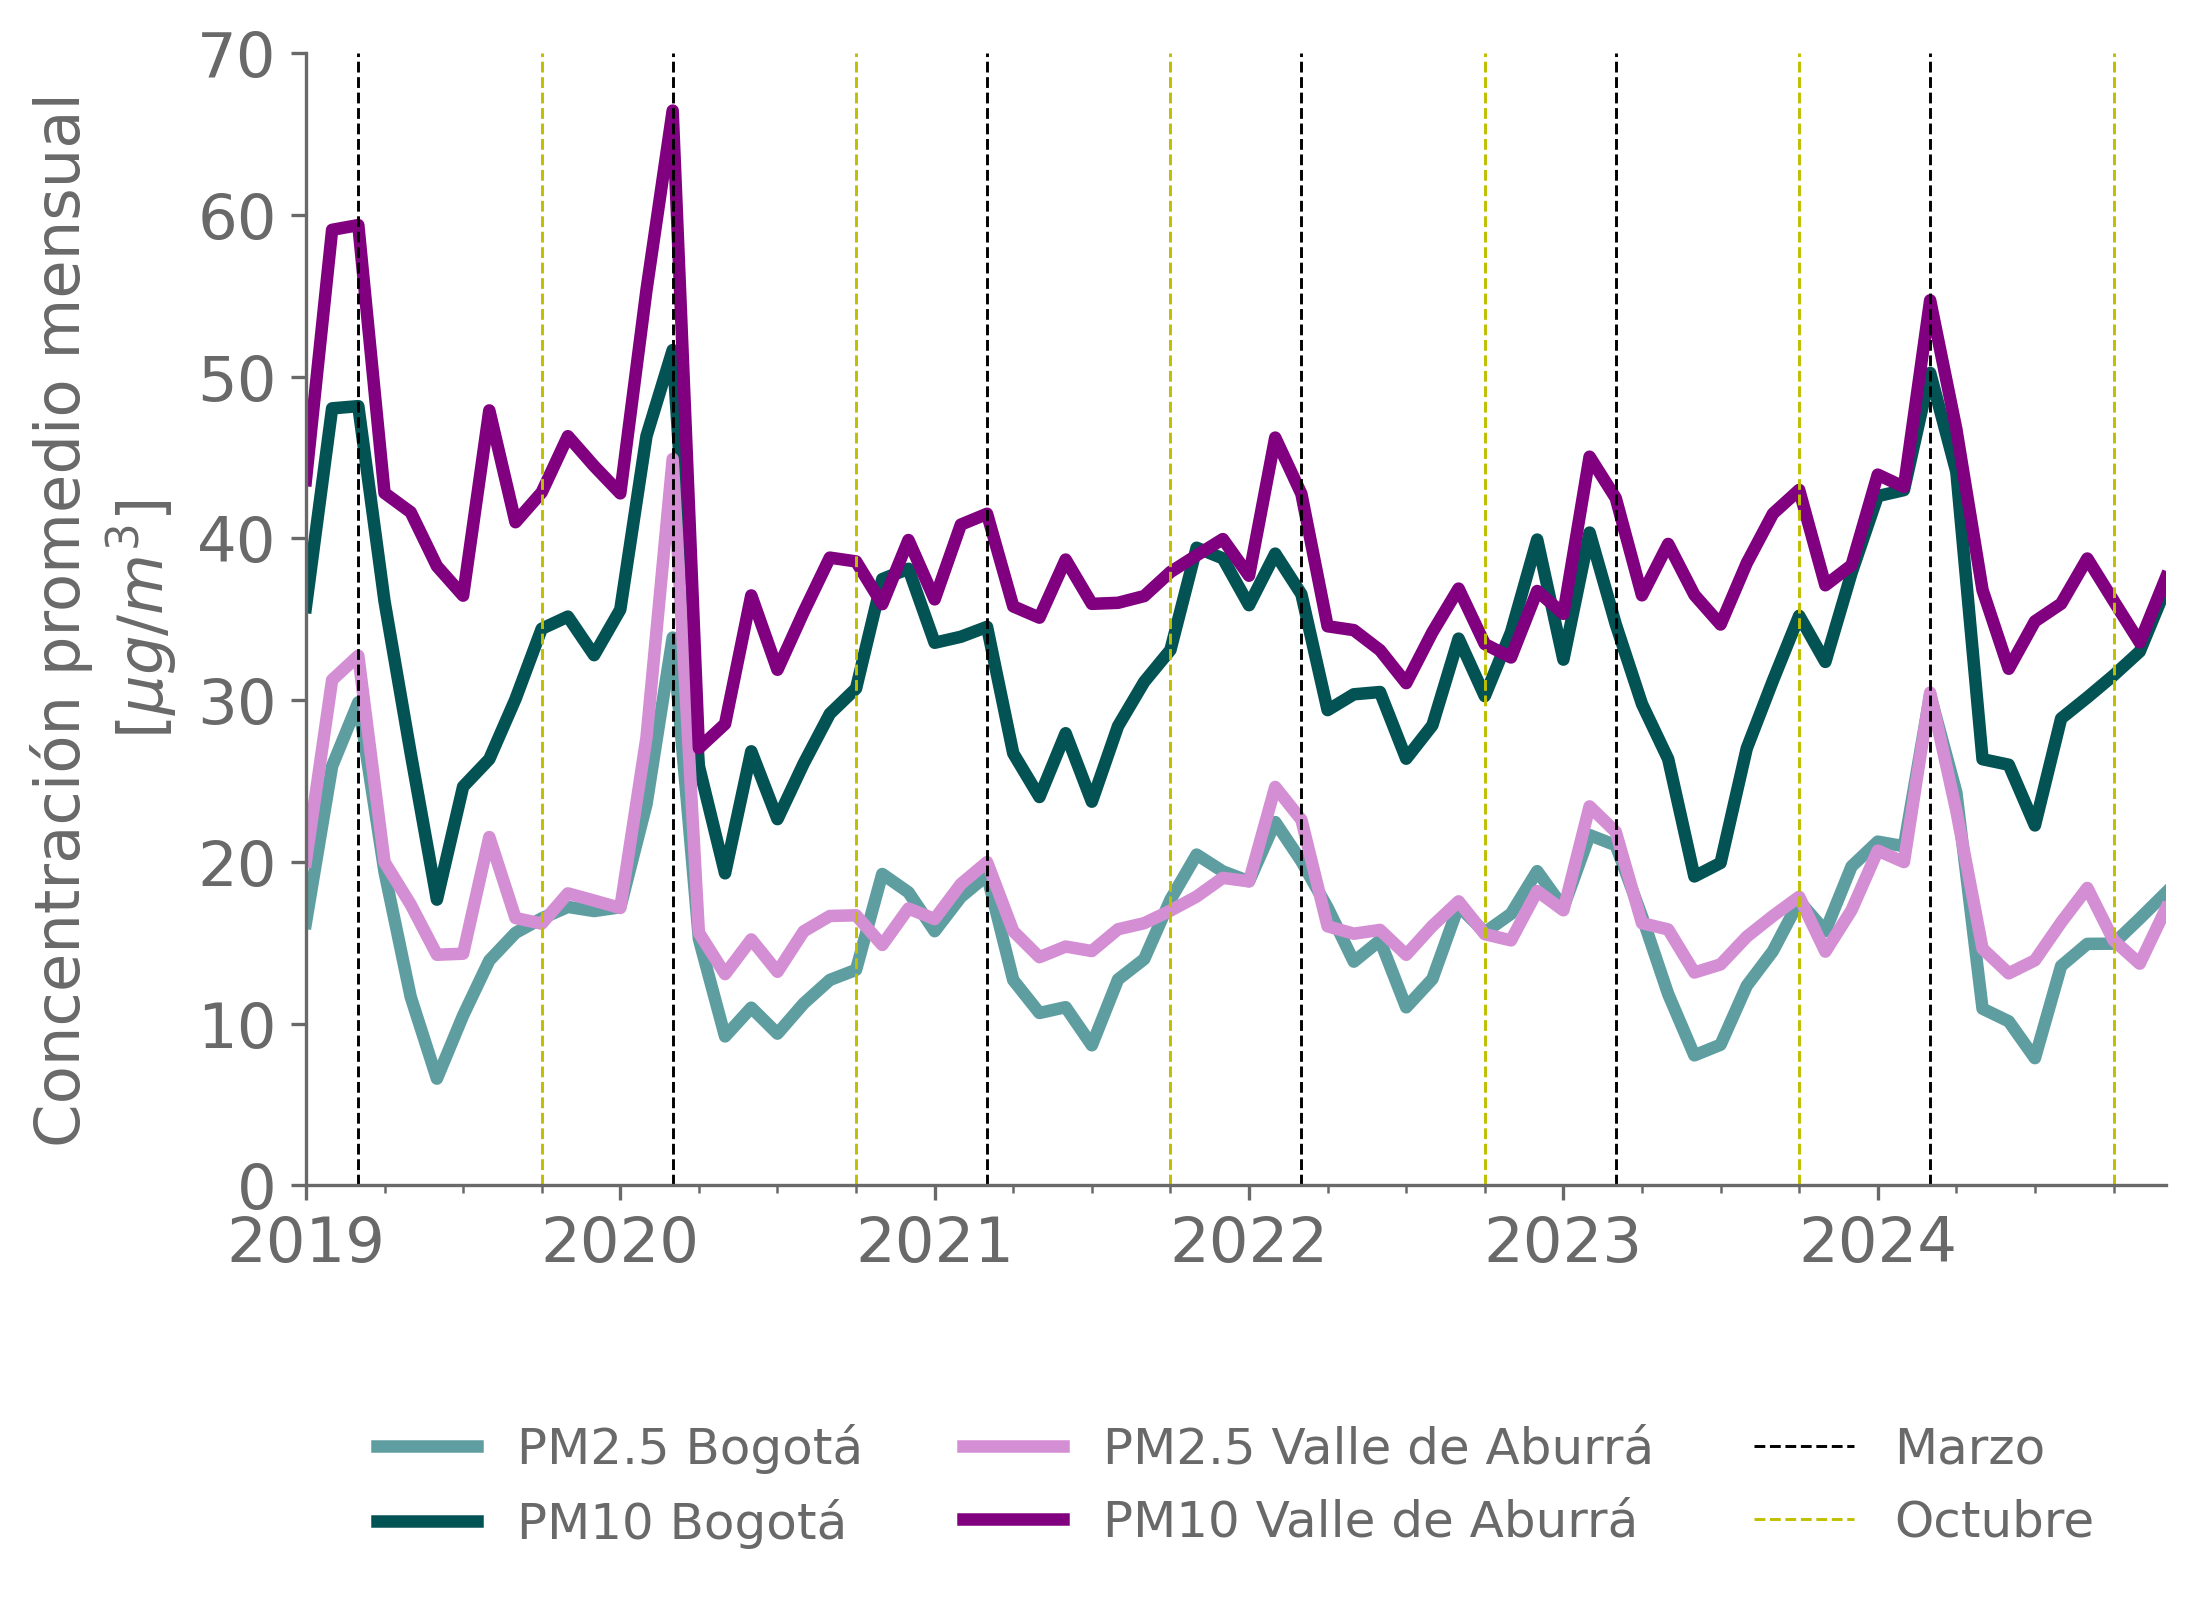

In [ ]:
# Set start and end dates
start_date = '2019-01-01 00:00'
end_date = '2024-12-31 23:59'
end_date_datetime = dt.datetime.strptime(end_date, '%Y-%m-%d %H:%M')

# Load air quality data for the Aburrá Valley
df_pm25 = read.PM25(Fechai=pd.to_datetime(start_date), Fechaf=end_date_datetime).data
df_pm10 = read.PM10(Fechai=pd.to_datetime(start_date), Fechaf=end_date_datetime).data

# Remove the 'ITA-POGO' column from the df_pm10 DataFrame
if 'ITA-POGO' in df_pm10.columns:
    df_pm10.drop(columns=['ITA-POGO'], inplace=True)
    print("Column 'ITA-POGO' successfully removed.")
else:
    print("Column 'ITA-POGO' does not exist in df_pm10.")

# Convert all columns to numeric format
df_pm25 = df_pm25.apply(pd.to_numeric, errors='coerce')
df_pm10 = df_pm10.apply(pd.to_numeric, errors='coerce')

# Create 'PM2.5_average' and 'PM10_average' columns as the mean per row
df_pm25['PM2.5_average'] = df_pm25.mean(axis=1)
df_pm10['PM10_average'] = df_pm10.mean(axis=1)

# Ensure the date columns are in datetime format and set as index
df_pm25.index = pd.to_datetime(df_pm25.index, errors='coerce')
df_pm10.index = pd.to_datetime(df_pm10.index, errors='coerce')

# Confirm that the columns were created
print(df_pm25[['PM2.5_average']].head())
print(df_pm10[['PM10_average']].head())


Columna 'ITA-POGO' eliminada correctamente.
                     PM2.5_average
2019-01-01 00:00:00      82.738450
2019-01-01 01:00:00      68.348785
2019-01-01 02:00:00      58.305385
2019-01-01 03:00:00      52.831776
2019-01-01 04:00:00      45.947776
                     PM10_average
2019-01-01 00:00:00     95.714286
2019-01-01 01:00:00     87.285714
2019-01-01 02:00:00     75.255825
2019-01-01 03:00:00     68.000000
2019-01-01 04:00:00     64.000000


In [ ]:
# Adjust column names in df_pm25 and df_pm10
df_pm25.rename(columns=lambda x: f"PM2.5_{x}" if not x.endswith("PM2.5_average") else x, inplace=True)
df_pm10.rename(columns=lambda x: f"PM10_{x}" if not x.endswith("PM10_average") else x, inplace=True)

# Create average columns if they are not already present
if 'PM2.5_average' not in df_pm25.columns:
    df_pm25['PM2.5_average'] = df_pm25.mean(axis=1)

if 'PM10_average' not in df_pm10.columns:
    df_pm10['PM10_average'] = df_pm10.mean(axis=1)

# Convert the index to datetime if it is not already
if not isinstance(df_pm25.index, pd.DatetimeIndex):
    df_pm25.index = pd.to_datetime(df_pm25.index)

if not isinstance(df_pm10.index, pd.DatetimeIndex):
    df_pm10.index = pd.to_datetime(df_pm10.index)

# Resample to obtain monthly averages
PM25_valley_month = df_pm25['PM2.5_average'].resample('M').mean()
PM10_valley_month = df_pm10['PM10_average'].resample('M').mean()

# Bogotá data already loaded and processed (dfs)
PM10_month = dfs['PM10_average'].resample('M').mean()
PM25_month = dfs['PM2.5_average'].resample('M').mean()

# Configure the plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the data
PM25_month.plot(ax=ax, color='CadetBlue', linestyle='-', linewidth=3, label='PM2.5 Bogotá')
PM10_month.plot(ax=ax, color='#035254', linestyle='-', linewidth=3, label='PM10 Bogotá')
PM25_valley_month.plot(ax=ax, color='#d48ed4', linestyle='-', linewidth=3, label='PM2.5 Aburrá Valley')
PM10_valley_month.plot(ax=ax, color='purple', linestyle='-', linewidth=3, label='PM10 Aburrá Valley')

# Vertical lines for March and October
march = [dt.date(y, 3, 15) for y in range(2019, 2025)]
october = [dt.date(y, 10, 15) for y in range(2019, 2025)]

for date in march:
    ax.axvline(date, color='k', linestyle='--', linewidth=0.7, label='March' if date == march[0] else None)

for date in october:
    ax.axvline(date, color='y', linestyle='--', linewidth=0.7, label='October' if date == october[0] else None)

# Annotations
bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="none", facecolor="white", alpha=0.5)
ax.annotate('Annual NMP\n(50 μg/m³)', xy=(mdates.date2num(dt.date(2022, 2, 20)), 50),
            color='CadetBlue', fontsize=13,
            xytext=(mdates.date2num(dt.date(2020, 8, 4)), 70),
            arrowprops=dict(color='powderblue', shrink=0.04), bbox=bbox_props)

ax.annotate('Annual NMP\n(25 μg/m³)', xy=(mdates.date2num(dt.date(2018, 8, 10)), 25),
            color='purple', fontsize=13,
            xytext=(mdates.date2num(dt.date(2018, 4, 4)), 80),
            arrowprops=dict(color='thistle', shrink=0.05), bbox=bbox_props)

# Customize the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('dimgrey')
ax.spines['bottom'].set_color('dimgrey')
ax.set_ylabel('Monthly average concentration\n['+'$\mu g/m^{3}$'+']', color='dimgrey', fontsize=15)
ax.tick_params(axis='both', which='both', colors='dimgrey', labelsize=15)
# Remove X-axis label
ax.set_xlabel('')
# Axis limits
ax.set_ylim(0, 70)

# Legend
leg = ax.legend(
    loc='upper center', bbox_to_anchor=(0.5, -0.17), fontsize=12, ncol=3, frameon=False
)
for text in leg.get_texts():
    plt.setp(text, color='dimgrey')

# Save and display
output_path = '/home/amontejo/jupyter/PM2.5/Bogota_AMVA_PM25/Bogota_Valley_PM_Graph.png'
fig.savefig(output_path, dpi=300, bbox_inches='tight')

fig.tight_layout()
fig.set_facecolor('w')
plt.show()


# Plot from 2013 to 2024 for the Aburrá Valley Metropolitan Area (AMVA)

- **PM2.5 Average**:
  - Dark green line: Monthly average PM2.5 concentration across monitoring stations.
  - Light green shaded area: Interquartile range (IQ Range), showing variability.

- **Seasonal Trends & Pollution Peaks**:
  - Recurring pollution peaks in **Feb–Apr** and **Sep–Nov**.
  - Seasonal variations influenced by meteorological conditions.

- **Key Months (Vertical Lines)**:
  - **Black dashed lines (March)**: Peak pollution season due to atmospheric stability.
  - **Yellow solid lines (October)**: Another critical pollution period.

- **PM2.5 Trends**:
  - Overall decreasing trend over the years.
  - Peaks persist, occasionally exceeding air quality standards.
  - Significant improvement in **baseline pollution levels** from **2013–2015** to **2023–2024**.

This keeps it structured and easy to integrate into your documentation! 🚀
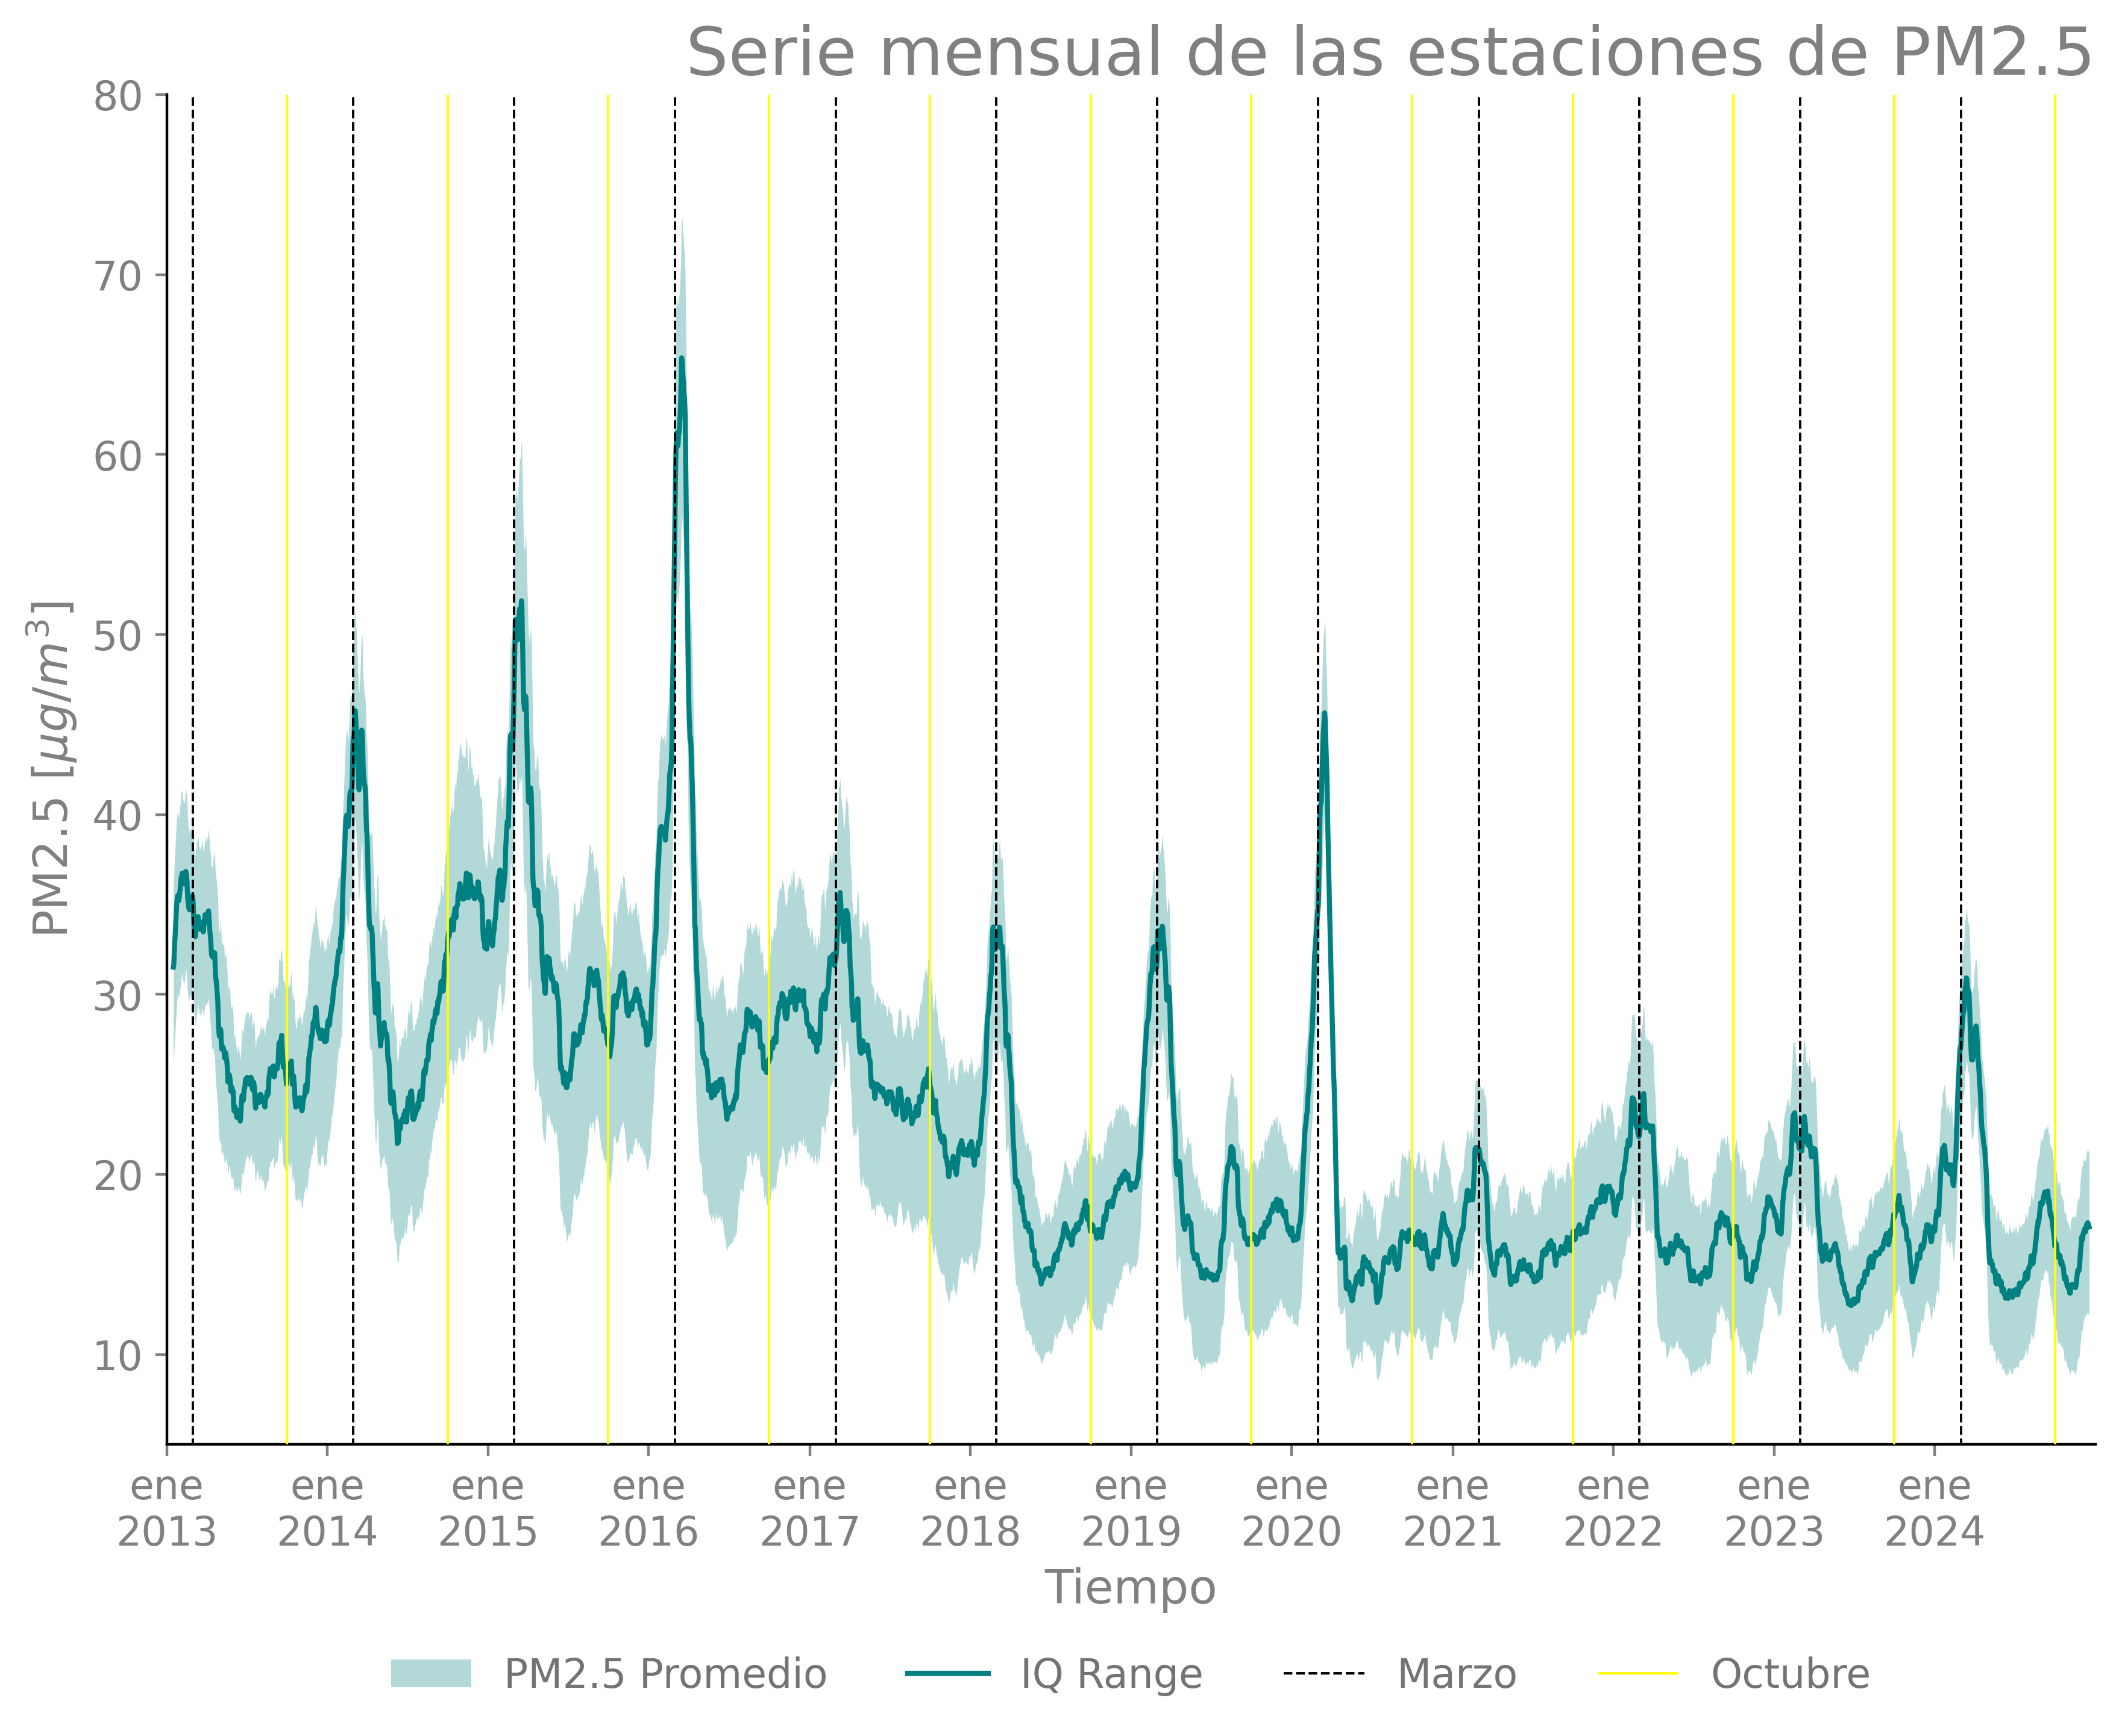

In [ ]:
# Set start and end dates
start_date = '2013-01-01 00:00'
end_date = '2024-12-31 23:59'
end_date_datetime = dt.datetime.strptime(end_date, '%Y-%m-%d %H:%M')

# Load air quality data for the Aburrá Valley
df_pm25 = read.PM25(Fechai=pd.to_datetime(start_date), Fechaf=end_date_datetime).data
df_pm10 = read.PM10(Fechai=pd.to_datetime(start_date), Fechaf=end_date_datetime).data

# Load Aburrá Valley data (ensure df_pm25 is correctly configured)
var = 'PM2.5'
meanC1 = df_pm25.mean(axis=1).resample('D').mean().rolling(30, center=True).mean()
iqC251 = df_pm25.quantile(0.25, axis=1).resample('D').mean().rolling(30, center=True).mean()
C751 = df_pm25.quantile(0.75, axis=1).resample('D').mean().rolling(30, center=True).mean()

# Configure the plot
plt.close('all')
fig = plt.figure(2, figsize=(10, 8), facecolor='w', edgecolor='w')
plt.subplots_adjust(wspace=.2, hspace=.35, bottom=0.2, left=0.1, right=0.9, top=0.8)
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["xtick.color"] = 'gray'
plt.rcParams["ytick.color"] = 'gray'

ax = {}
ax[1] = fig.add_axes((0.1, 0.1, 0.8, 0.7))

# Fill between the 25th and 75th percentiles
ax[1].fill_between(iqC251.index, iqC251, C751, alpha=0.3, color='teal', lw=0, label='IQ Range')
ax[1].plot(meanC1.index, meanC1, color='teal', label='PM2.5 Average')

# Y-axis settings
ax[1].set_ylabel('PM2.5 [$\mu g/m^3$]', color='gray', fontsize=14)
ax[1].set_ylim(5, 80)

# Vertical lines for March and October of each year
for y in range(2013, 2025):
    ax[1].vlines(dt.date(y, 3, 1), 0, 120, color='k', linestyle='--', linewidth=0.7, zorder=3, label='March' if y == 2013 else None)
    ax[1].vlines(dt.date(y, 10, 1), 0, 120, color='yellow', linestyle='-', linewidth=0.7, zorder=3, label='October' if y == 2013 else None)

# X-axis settings
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax[1].xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax[1].xaxis_date()
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_xlim([dt.date(2013, 1, 1), dt.date(2024, 12, 31)])
ax[1].tick_params(axis='x', which='both', bottom=True, top=False, direction='out')
ax[1].tick_params(axis='x', colors='gray', right=True, left=True)

# Labels and title
ax[1].set_xlabel('Time', color='gray', fontsize=14)
ax[1].set_title('Monthly Time Series of PM2.5 Stations', fontsize=20, loc='right', color='gray')

# Legend
leg = ax[1].legend(['PM2.5 Average', 'IQ Range', 'March', 'October'], bbox_to_anchor=(0.5, -0.13), loc='upper center', fontsize=12, ncol=4, frameon=False)
for text in leg.get_texts():
    plt.setp(text, color=(0.45, 0.45, 0.45))

# Save the plot
output_path = '/home/amontejo/jupyter/PM2.5/Bogota_AMVA_PM25/ConcentrationTendencies_PM25_Valle.png'
plt.savefig(output_path, dpi=400, bbox_inches='tight')
print(f'Graph saved at: {output_path}')

plt.show()

Gráfica guardada en: /home/amontejo/jupyter/PM2.5/Bogota_AMVA_PM25/ConcentrationTendencies_PM25_Valle.png
